# ME2105 Meteorologi Dinamik I (Semester III 2019/2020)
# Teori Dinamika Monsun

## Referensi:

Chang, C. P., Wang, Z., Mc Bride, J., Liu, C. H. (2004) : Annual Cycle of Southeast Asia-Maritime Continent Rainfall and the Assymmetric Monsoon Transition, Journal of Climate 18:2, 287-301.

D.S. Wilks, STATISTICAL METHODS IN THE ATMOSPHERIC SCIENCES


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import xarray as xr
from scipy import integrate

In [2]:
#data precip
Pr=xr.open_dataset('Data/prate.sfc.mon.mean.nc')
#konversi rainrate (mm/s) ke ch akumulasi (mm/bulan)
ndays = Pr.time.dt.days_in_month
Prec=Pr.prate*3600*24*ndays
#klimatologi
precClim=Prec.groupby('time.month').mean(dim='time')

In [3]:
#koordinat bandung
ilon=107.609918
ilat=-6.890670 
tsCH=precClim.sel(lon=ilon,lat=ilat,method='nearest')

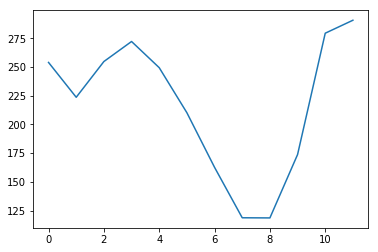

In [4]:
plt.plot(tsCH)

## Analisa Harmonik

In [9]:
def fharmonic(Y):
    """
    Fungsi Analisa Harmonik dengan menggunakan MLR
    Input: timeseries yang telah dibuang Mean-nya
    Output: C (amplitude), theta (sudut fasa), dan Yi (sinyal harmonik) dari masing-masing k (bilangan gelombang) 
    """ 
    import numpy as np
    from sklearn import linear_model
    #Persamaan C(k)*cos(2*pi*k*t/n - theta(k)) dapat dijabarkan menjadi
    #persamaan: A(k)*cos(2pi*kt/n) + B(k)*sin(2pi*kt/n)
    #Parameter A dan B dicari dengan memecahkan multiple linear regression
    #dari persamaan y = A(1)*x1 + B(1)*x2 + A(2)*x3 + B(2)*x4 + .... dst
    #dengan x1=cos(2pi*1*t/n)    ,k=1
    #       x2=sin(2pi*1*t/n)    ,k=1
    #       x3=cos(2pi*2*t/n)    ,k=2
    #       x4=sin(2pi*2*t/n)    ,k=2
    #       x5=sin(2pi*3*t/n)    ,k=3
    #       x6=sin(2pi*3*t/n)    ,k=3
    #       ... dst
    #A dan B selanjutnya digunakan untuk mengestimasi nilai C dan THETA
    n=Y.size
    X=np.empty([0,n])
    t = np.linspace(1, n, n)    
    for k in range(1,int(np.fix(n/2))+1):
        x_o=np.cos(2*np.pi*k*t/n) #ganjil
        x_e=np.sin(2*np.pi*k*t/n) #genap
        X=np.vstack((X,x_o,x_e))
    #transpose X
    X=X.transpose()
    #fitting ke fungsi MLR
    reg=linear_model.LinearRegression().fit(X,Y)
    #koefisien regresinya 
    b=reg.coef_
    A=b[0:n:2] #ganjil
    B=b[1:n:2] #genap
    #hitung C dan theta
    C=np.sqrt((A**2)+(B**2))
    theta=t[0:int(np.fix(n/2))]*np.nan
    theta[A>0.0]=np.arctan(B[A>0.0]/A[A>0.0])
    theta[A<0.0]=np.arctan(B[A<0.0]/A[A<0.0])+np.pi
    theta[A==0.0]=np.pi/2
    #persamaan harmonik-nya
    yi=np.empty([int(np.fix(n/2)),n])
    yi=np.matrix.transpose(yi)
    for k in range(0,int(np.fix(n/2))):
        yi[:,k-1]=(C[k-1]*np.cos((2*np.pi*k*t/n) - (theta[k-1])));
    k=np.linspace(1,int(np.fix(n/2)),int(np.fix(n/2)))

    return C,theta,yi,k

In [10]:
#output: C (amplitude), theta (sudut fasa), k (bilangan gelombang), yk (sinyal masing-masing harmonik)
Ck,thetak,yk,k=fharmonic(tsCH)

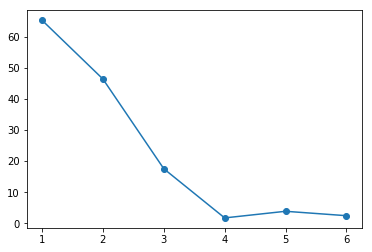

In [14]:
plt.plot(k,Ck,'o-')

In [18]:
np.mean(tsCH.data)

217.3599697649183

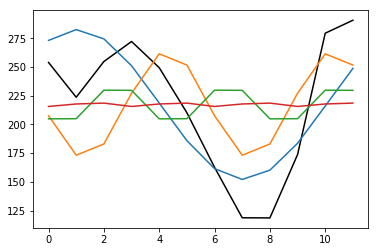

In [24]:
fig,ax=plt.subplots()
ax.plot(tsCH,'k')
ax.plot(yk[:,0]+np.mean(tsCH.data))
ax.plot(yk[:,1]+np.mean(tsCH.data))
ax.plot(yk[:,2]+np.mean(tsCH.data))


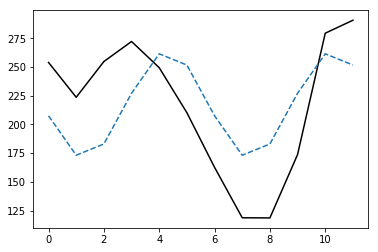

In [32]:
fig,ax=plt.subplots()
ax.plot(tsCH,'k')
ax.plot(np.sum(yk[:,1:2],axis=1)+np.mean(tsCH.data),'--')